In [1]:
import sys
sys.path.append('..')
import torch
from torchvision import datasets, transforms
from models import VAE, loss_function
from problems import get_problem
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

p = get_problem('sum_25', 'int', train_ratio=1.)

def get_digit(digit, train):
    test_digits = []
    for data, label in datasets.MNIST('../data', train=train, download=True, transform=transforms.ToTensor()):
        if digit == -1 or label.item() == digit:
            test_digits.append((data, label))
    return test_digits

In [2]:
# Load some problems
uniform = get_problem('uniform', 'int', train_ratio=1.)
sum_25 = get_problem('sum_25', 'int', train_ratio=1.)
increasing = get_problem('increasing', 'int', train_ratio=1.)
symmetric = get_problem('symmetric', 'int', train_ratio=1.)
even = get_problem('even', 'int', train_ratio=1.)

In [332]:
# Load all Gaussians
gaussian_models = torch.load('gaussian_models.pkl')
gaussian_models['mean']

# Sample from diagonal gaussian
def sample_diag(digit, means, var):
    z = torch.randn(len(var[digit]))
    x = means[digit] + torch.sqrt(var[digit]) * z
    print (torch.sqrt(var[digit])).size()
    return x

# Sample from full gaussian
def sample_full(digit, means, cholesky):
    z = torch.randn(len(cholesky[digit]))
    x = means[digit] + cholesky[digit].matmul(z)
    return x

sample = sample_full(8, gaussian_models['mean'], gaussian_models['cholesky'])

import scipy.stats
gaussians = {}
REGULARIZATION = 1e-3
for i in xrange(10):
    gaussian = scipy.stats.multivariate_normal(mean=gaussian_models['mean'][i],
                                   cov=np.identity(784)*REGULARIZATION + gaussian_models['fullvar'][i])
    gaussians[i] = gaussian
    
sample = sample_full(2, gaussian_models['mean'], gaussian_models['cholesky'])
gaussians[3].logpdf(sample)

# Build visual models (from Full Gaussians)
def create_visual_model(digit_idx, gaussian_models, REGULARIZATION=1e-3):
    gaussian = scipy.stats.multivariate_normal(mean=gaussian_models['mean'][digit_idx],
                                       cov=np.identity(784)*REGULARIZATION + gaussian_models['fullvar'][digit_idx])
    def visual_model(digit_image):
        x = digit_image.view(-1)
        nll = - gaussian.logpdf(x)
        return nll
    return visual_model
visual_models = [create_visual_model(i, gaussian_models) for i in xrange(10)]

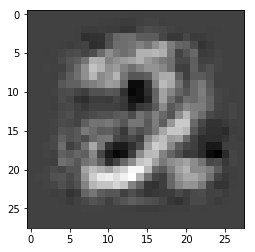

In [287]:
plt.imshow(sample.numpy().reshape(28,28), cmap='gray')

In [3]:
# Load all VAES
vaes = {}
#EPOCH = 80
EPOCH = 70
for i in xrange(10):
    vae = VAE()
    state_dict = torch.load('epoch_{}/digit_{}_epoch_{}.pth'.format(EPOCH, i, EPOCH))
    vae.load_state_dict(state_dict)
    vaes[i] = vae
    
# Build visual models (from VAEs)
def create_visual_model(digit_idx, vaes):
    def visual_model(digit_image):
        x = digit_image.view((1, 1, 28, 28))
        reconstruction, mu, logvar = vaes[digit_idx](x)
        nll = loss_function(reconstruction, x, mu, logvar)
        return nll
    return visual_model
visual_models = [create_visual_model(i, vaes) for i in xrange(10)]

In [4]:
# Load all MNISTs
batch_size = 1

# Load all MNIST digits
test_digits = {}
test_loaders = {}
for i in xrange(10):
    print 'Loading digit', i
    test_digit = get_digit(i, train=False)
    test_digits[i] = test_digit
    
    test_loader = torch.utils.data.DataLoader(test_digit, batch_size=batch_size, shuffle=True)
    test_loaders[i] = test_loader
    
# Build visual samplers (from test set)
def create_visual_sampler(i, test_loaders):
    def visual_sampler():
        return iter(test_loaders[int(i)]).next()[0][0,0]
    return visual_sampler
visual_samplers = [create_visual_sampler(i, test_loaders) for i in xrange(10)]

print visual_samplers[8]().size()

Loading digit 0
Loading digit 1
Loading digit 2
Loading digit 3
Loading digit 4
Loading digit 5
Loading digit 6
Loading digit 7
Loading digit 8
Loading digit 9
torch.Size([28, 28])


# Symbolic Combination to Image Combination

Size torch.Size([5, 28, 28])


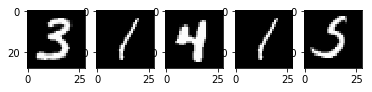

In [5]:
# Combination to Visual
def to_visual(combination, visual_samplers):
    '''
    Sample a visual representation for a symbolic combination
    
    Parameters
    ----------
    combination: np.ndarray (part~5) combination to encode
    visual_samplers: dict of 10 callable objects which return a random corresponding (28, 28) digit
    
    Returns
    -------
    visual_combination: torch.Tensor (part~5, height~28, width~28)
    '''
    x = []
    for c in combination:
        sample = visual_samplers[c]()
        x.append(sample[None, :, :])
    visual_combination = torch.cat(x)
    return visual_combination

# Test: combination to visual_combination    
visual_combination = to_visual([3, 1, 4, 1, 5], visual_samplers)

print 'Size', visual_combination.size()
for i in xrange(5):
    plt.subplot(1,5,i+1)
    plt.imshow(visual_combination[i].numpy(), cmap='gray')

# Likelihood of Sum-25 with Joint generator

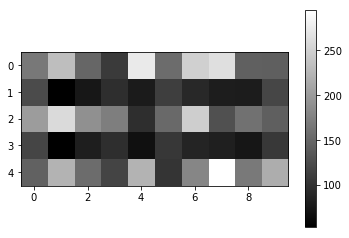

In [6]:
# Precompute conditional visual likelihoods
def get_per_digit_likelihood(visual_combination, visual_models):  # return -log likelihoods
    '''
    Compute NLL given by each visual model (e.g. VAE) to each visual digit.
    
    Parameters
    ----------
    visual_combination: torch.Tensor (part~5, height~28, width~28)
    visual_models: dictionary of objects which can be called on x and return a nll

    Return
    ------
    visual_likelihoods: np.ndarray (part~5, digit~10)
    ''' 
    visual_likelihoods = np.zeros((5, 10))
    for part in xrange(5):
        for model_idx in xrange(10):
            digit_image = visual_combination[part]
            l = visual_models[model_idx](digit_image)
            visual_likelihoods[part, model_idx] = l  # since it's -log likelihood
    return visual_likelihoods

# Test: get conditional nll for each digit of visual combination
visual_likelihoods = get_per_digit_likelihood(visual_combination, visual_models)
plt.imshow(visual_likelihoods, 'gray')
plt.colorbar()


In [7]:
# Sum over all combinations in symbolic model
conditional_likelihoods = []

def log_sum_exp(v):
    v = np.asarray(v)
    v_max = v.max()
    return v_max + np.log(np.sum(np.exp(v - v_max)))


def get_one_sample_likelihood(visual_likelihoods, model_combinations):
    '''
    Return likelihood given by a joint model for one visual sample.
    
    Parameters
    ----------
    visual_likelihoods: np.ndarray (part~5, digit~10) of per_digit likelihoods
    model_combinations: np.ndarray (combination~1000, part~5) 
        symbolic model is uniform distribution on those combinations.
    
    Returns
    -------
    likelihood: nll for that given sample: -log { 1/|C| sum_{z\in C} p(z) \prod_i p(x_i | z_i) }
    conditional_likelihoods: -\sum_i \log p(x_i | z_i)
    closest_combination: return combination z in model_combinations with highest likelihood
    '''
    conditional_likelihoods = []
    for combination in model_combinations:  # iterate over possible z
        tmp = 0.
        for part, c in enumerate(combination):
            p_xPart_given_zPart = visual_likelihoods[part, c]
            tmp += p_xPart_given_zPart
        conditional_likelihoods.append(tmp)
    likelihood = np.log(len(model_combinations)) - log_sum_exp(-np.asarray(conditional_likelihoods))  # get NLL
    # for debugging return closest combination
    best_x_z = np.argmin(conditional_likelihoods)  # smallest log likelihood
    closest_combination = model_combinations[best_x_z]
    return likelihood, conditional_likelihoods, closest_combination
    
    
# Test: get liklelihood for sample giving visual_likelihood
likelihood, conditional_likelihoods, closest_combination = get_one_sample_likelihood(
    visual_likelihoods, sum_25.train_positive)

# Note that the largest conditional likelihood should correspond classifying the combination
# if combination verifies constraint
print 'Closest combination match', closest_combination
print 'Likelihood', likelihood

Closest combination match [3 7 4 6 5]
Likelihood 482.86708156528493


# Repeat this over all training set combinations X model combinations
[Main Function]

In [8]:
def get_likelihood(target_combinations, model_combinations,
                    visual_samplers, visual_models, max_iterations=200):
    '''
    Return estimated likelihood for 
    '''
    all_likelihoods = []
    for i, combination in enumerate(target_combinations):  # true distribution to reach
        
        if i >= max_iterations:
            break
        
        # Transform symbolic combination to visual
        visual_combination = to_visual(combination, visual_samplers)
        
        # Compute likelihood of each part(digit) with each visual conditional model 
        visual_likelihoods = get_per_digit_likelihood(visual_combination, visual_models)  
        
        # Compute likelihood of that visual sample
        likelihood, conditional_likelihoods, closest_combination = get_one_sample_likelihood(
            visual_likelihoods, model_combinations)  # model distribution

        # Logging
        all_likelihoods.append(likelihood)
        average_nll = np.mean(all_likelihoods)
        std = np.std(all_likelihoods) / np.sqrt(len(all_likelihoods))
        if i % 50 == 0:
            print 'Combination #', i
            print 'Combination', combination
            print 'closest', closest_combination
            print 'Likelihood', likelihood
            print 'NLL in [{:.1f}; {:.1f}]'.format(average_nll-std, average_nll+std)  
            
    return average_nll, std

target_combinations = sum_25.train_positive
model_combinations = sum_25.train_positive
average_nll, std = get_likelihood(target_combinations, model_combinations,
                    visual_samplers, visual_models, max_iterations=200)

print 'NLL in [{:.1f}; {:.1f}]'.format(average_nll-std, average_nll+std)

Combination # 0
Combination [9 0 2 8 6]
closest [9 0 2 8 6]
Likelihood 541.0409114048445
NLL in [541.0; 541.0]
Combination # 50
Combination [4 9 1 3 8]
closest [4 9 1 3 8]
Likelihood 429.1041743442976
NLL in [476.4; 490.6]
Combination # 100
Combination [3 7 8 1 6]
closest [3 7 8 1 6]
Likelihood 414.40949508404367
NLL in [484.2; 494.3]
Combination # 150
Combination [0 8 9 2 6]
closest [0 8 9 2 6]
Likelihood 485.4522502109968
NLL in [484.7; 493.1]
NLL in [484.3; 491.7]


# Actual tests

In [9]:
max_iterations = 1000

In [10]:
target_combinations = sum_25.train_positive
model_combinations = uniform.train_positive
average_nll, std = get_likelihood(target_combinations, model_combinations,
                    visual_samplers, visual_models, max_iterations=max_iterations)

Combination # 0
Combination [9 0 2 8 6]
closest [9 0 2 8 6]
Likelihood 591.522726748477
NLL in [591.5; 591.5]


KeyboardInterrupt: 

In [11]:
target_combinations = sum_25.train_positive
model_combinations = uniform.train_positive
average_nll, std = get_likelihood(target_combinations, model_combinations,
                    visual_samplers, visual_models, max_iterations=200)

Combination # 0
Combination [9 0 2 8 6]
closest [9 0 2 3 6]
Likelihood 583.6769393552838
NLL in [583.7; 583.7]


KeyboardInterrupt: 

In [12]:
all_problems = ['sum_25', 'increasing', 'symmetric', 'even']
uniform = get_problem('uniform', 'int', train_ratio=1.)
max_iterations = 2000

# (key_1, key_2) key_1 is target, key_2 is model
average_nlls = {}
stds = {}

for p in all_problems:
    target_problem = get_problem(p, 'int', train_ratio=1.)
    # Compute target vs. uniform model
    print '\n{} with {}-model'.format(p, 'UNIFORM')
    average_nll, std = get_likelihood(target_problem.train_positive, uniform.train_positive,
                    visual_samplers, visual_models, max_iterations=max_iterations)
    average_nlls[(p, 'uniform')] = average_nll
    stds[(p, 'uniform')] = std
    # Compute target vs. target model
    print '\n{} with {}-model'.format(p, p)
    average_nll, std = get_likelihood(target_problem.train_positive, target_problem.train_positive,
                    visual_samplers, visual_models, max_iterations=max_iterations)
    average_nlls[(p, p)] = average_nll
    stds[(p, p)] = std    
    


sum_25 with UNIFORM-model
Combination # 0
Combination [4 8 8 3 2]
closest [4 8 8 3 2]
Likelihood 511.430874892179
NLL in [511.4; 511.4]
Combination # 50
Combination [9 4 2 2 8]
closest [9 4 2 2 8]
Likelihood 494.2050237034475
NLL in [492.0; 506.6]
Combination # 100
Combination [3 7 5 3 7]
closest [3 7 8 3 7]
Likelihood 504.66052527384505
NLL in [486.6; 497.4]
Combination # 150
Combination [8 4 6 6 1]
closest [8 4 6 6 1]
Likelihood 461.3395856149088
NLL in [487.5; 496.6]
Combination # 200
Combination [6 2 9 1 7]
closest [6 2 9 1 7]
Likelihood 459.26342382566185
NLL in [490.3; 498.0]
Combination # 250
Combination [6 6 5 6 2]
closest [6 6 5 6 3]
Likelihood 496.0078641734652
NLL in [491.5; 498.5]
Combination # 300
Combination [7 7 3 3 5]
closest [7 7 3 3 5]
Likelihood 542.5146801592792
NLL in [492.5; 498.7]
Combination # 350
Combination [1 7 4 8 5]
closest [1 7 4 8 0]
Likelihood 494.6953020690899
NLL in [491.1; 496.8]
Combination # 400
Combination [3 9 8 3 2]
closest [3 9 8 3 8]
Likelihoo

Combination # 1600
Combination [8 3 8 2 4]
closest [8 3 8 2 4]
Likelihood 547.7248103306257
NLL in [485.5; 488.2]
Combination # 1650
Combination [5 6 4 9 1]
closest [5 6 4 9 1]
Likelihood 457.48636886334054
NLL in [485.9; 488.7]
Combination # 1700
Combination [7 6 3 7 2]
closest [7 6 3 7 2]
Likelihood 474.23954269146554
NLL in [485.9; 488.6]
Combination # 1750
Combination [8 4 3 3 7]
closest [8 4 3 3 7]
Likelihood 473.263087002989
NLL in [485.9; 488.5]
Combination # 1800
Combination [3 2 5 8 7]
closest [3 2 5 8 7]
Likelihood 545.9453608677351
NLL in [486.1; 488.7]
Combination # 1850
Combination [8 1 2 5 9]
closest [8 1 2 5 9]
Likelihood 520.0683886692487
NLL in [486.1; 488.6]
Combination # 1900
Combination [6 3 2 7 7]
closest [6 3 2 7 7]
Likelihood 497.4941279575787
NLL in [485.8; 488.3]
Combination # 1950
Combination [5 9 4 1 6]
closest [5 9 4 1 6]
Likelihood 373.25814697003
NLL in [486.1; 488.6]

increasing with UNIFORM-model
Combination # 0
Combination [0 2 5 6 9]
closest [0 2 5 6 9

Combination # 1200
Combination [4 5 5 8 8]
closest [4 5 5 5 8]
Likelihood 573.3253440375119
NLL in [482.9; 486.6]
Combination # 1250
Combination [3 3 6 7 7]
closest [3 3 6 7 7]
Likelihood 448.91122813135985
NLL in [482.8; 486.5]
Combination # 1300
Combination [2 2 3 5 6]
closest [2 2 3 5 6]
Likelihood 548.6344642157345
NLL in [482.5; 486.0]
Combination # 1350
Combination [1 7 7 7 9]
closest [1 7 7 7 9]
Likelihood 423.30007166753217
NLL in [482.1; 485.5]
Combination # 1400
Combination [2 2 8 8 9]
closest [2 2 8 8 9]
Likelihood 540.0681190008908
NLL in [481.8; 485.3]
Combination # 1450
Combination [5 6 7 7 9]
closest [5 6 7 7 9]
Likelihood 440.87571330020717
NLL in [481.4; 484.7]
Combination # 1500
Combination [0 0 0 2 9]
closest [0 0 0 2 9]
Likelihood 483.10490031192455
NLL in [480.8; 484.1]
Combination # 1550
Combination [1 1 3 5 8]
closest [1 1 3 5 8]
Likelihood 425.88505930417176
NLL in [480.9; 484.1]
Combination # 1600
Combination [4 6 7 8 9]
closest [4 6 7 8 9]
Likelihood 458.66133

Combination # 800
Combination [4 0 8 6 8]
closest [4 0 8 6 8]
Likelihood 487.7033753274031
NLL in [478.4; 482.3]
Combination # 850
Combination [0 4 0 3 3]
closest [0 4 0 3 3]
Likelihood 535.9797810835684
NLL in [478.9; 482.7]
Combination # 900
Combination [6 9 4 8 1]
closest [6 9 4 8 1]
Likelihood 366.5322125707259
NLL in [478.4; 482.1]
Combination # 950
Combination [8 0 3 7 2]
closest [8 0 3 7 2]
Likelihood 537.6568156300082
NLL in [479.2; 482.9]
Combination # 1000
Combination [7 6 2 8 7]
closest [7 6 2 8 7]
Likelihood 470.5449530285945
NLL in [480.0; 483.6]
Combination # 1050
Combination [4 3 5 5 7]
closest [4 3 5 5 7]
Likelihood 584.4553118059251
NLL in [480.6; 484.1]
Combination # 1100
Combination [8 3 0 3 4]
closest [8 3 0 3 4]
Likelihood 521.8600705454677
NLL in [481.1; 484.5]
Combination # 1150
Combination [1 3 9 3 4]
closest [1 3 4 3 4]
Likelihood 459.69429804528295
NLL in [480.7; 484.0]
Combination # 1200
Combination [4 6 2 8 0]
closest [4 6 2 8 0]
Likelihood 541.0362408946577

In [13]:
average_nlls

{('even', 'even'): 482.881828224345,
 ('even', 'uniform'): 482.4376903098824,
 ('increasing', 'increasing'): 482.8828497003174,
 ('increasing', 'uniform'): 483.88954844879936,
 ('sum_25', 'sum_25'): 487.30338702714334,
 ('sum_25', 'uniform'): 488.86733299226444,
 ('symmetric', 'symmetric'): 483.72931076816843,
 ('symmetric', 'uniform'): 485.75724959077826}

In [14]:
stds

{('even', 'even'): 1.29698143891718,
 ('even', 'uniform'): 1.2555102172392867,
 ('increasing', 'increasing'): 1.4124072897138509,
 ('increasing', 'uniform'): 1.370912389789672,
 ('sum_25', 'sum_25'): 1.2415188473171475,
 ('sum_25', 'uniform'): 1.199128668667483,
 ('symmetric', 'symmetric'): 2.2195362444393814,
 ('symmetric', 'uniform'): 2.1449975235888186}

In [16]:
lines = []
for key in average_nlls:
    lines.append('{}: {:.1f} +/- {:.1f}'.format(key, average_nlls[key], stds[key]))
lines = sorted(lines)
print '\n'.join(lines)

('even', 'even'): 482.9 +/- 1.3
('even', 'uniform'): 482.4 +/- 1.3
('increasing', 'increasing'): 482.9 +/- 1.4
('increasing', 'uniform'): 483.9 +/- 1.4
('sum_25', 'sum_25'): 487.3 +/- 1.2
('sum_25', 'uniform'): 488.9 +/- 1.2
('symmetric', 'symmetric'): 483.7 +/- 2.2
('symmetric', 'uniform'): 485.8 +/- 2.1


In [ ]:
key